In [ ]:
from jira import JIRA
import pandas as pd
options = {"server": "https://issues.apache.org/jira", 'verify': False}
conn = JIRA(options)
block_size = 1000
block_num = 0
allissues = []
project_str = 'project="HADOOP"'
while True:
 start_idx = block_num*block_size
 issues = conn.search_issues(project_str, start_idx, block_size)
 if len(issues) == 0:
 # Retrieve issues until there are no more to come
     break
 block_num += 1
 for issue in issues:
 #log.info('%s: %s' % (issue.key, issue.fields.summary))
     allissues.append(issue)

In [ ]:
# Takes all field names contained in each issue and adds to a list, fn
fn = []
for issue in allissues:
    for field_name in issue.raw['fields']:
        if field_name not in fn:
            fn.append(field_name)

In [ ]:
import numpy as np

# Takes all issues and adds to pandas DataFrame, each fieldname is a column

df = pd.DataFrame()
list1 = []
for issue in allissues:
    d = {}
    i = 0
    for field in fn:
        try: 
            d[fn[i]] = getattr(issue.fields, fn[i])
        except:
            d[fn[i]] = None
        i+=1
    df = df.append(d, ignore_index = True)

In [ ]:
# Saves dataframe

df.to_csv("data_all")

In [90]:
# Load dataframe and make a copy to work with

data = pd.read_csv("data_all")
data.head()
data1 = data.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (13,21,22,54,96) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [91]:
# Extract columns which will be used as input to neural network and issuetype (label)

features_to_keep = ['description',
                   'issuetype', 
                   'priority',
                   'resolution',
                   'status',
                   'summary',
                   'components',   
                   'parent', 
                   ]

data1 = data1.loc[:, features_to_keep]
data1.head()

,description,issuetype,priority,resolution,status,summary,components,parent
0,https://github.com/FasterXML/jackson-databind/...,Bug,Major,NaN,Open,upgrade jackson-databind to 2.13.2.1 due to cve,[],NaN
1,Document S3PrefetchingInputStream for users (...,Sub-task,Major,NaN,Open,document use and design of prefetching s3a inp...,"[<JIRA Component: name='documentation', id='12...",HADOOP-18028
2,This has to be a blocker for the merge I'm afr...,Sub-task,Major,NaN,Open,s3a prefetching stream to move off twitter Fut...,"[<JIRA Component: name='fs/s3', id='12311814'>]",HADOOP-18028
3,identify and fix all test regressions from the...,Sub-task,Major,NaN,Open,test failures with prefetching s3a input stream,"[<JIRA Component: name='fs/s3', id='12311814'>...",HADOOP-18028
4,In our project we are using hadoop-client libr...,Bug,Major,NaN,Open,IBM Java detected while running on OpenJDK cla...,[],NaN


In [92]:

data1['parent'] = data1['parent'].fillna('0')


In [93]:
i = 0
for col in data1:
    print(col, "amount of data contained: ", data1.iloc[:,i].count() / len(data1))
    i += 1

description amount of data contained:  0.9677480196152395
issuetype amount of data contained:  1.0
priority amount of data contained:  1.0
resolution amount of data contained:  0.8351565447001131
status amount of data contained:  1.0
summary amount of data contained:  1.0
components amount of data contained:  1.0
parent amount of data contained:  1.0


In [94]:
# Creates new column label and assignes numerical value to issuetypes, as this is the form the neural network needs the labels in

i = 0
other = ['New Feature', 'Task', 'Wish', 'Test']
data1['label'] = ""
for t in data1.issuetype:
  if t == "Bug":
    data1.label[i] = 0
  elif t == "Improvement":
    data1.label[i] = 1
  elif t == "Sub-task":
    data1.label[i] = 2
  elif t in other:
    data1.label[i] = 3
  i += 1

In [95]:
for col in data1:
  print(col, ":", len(data1[col].unique()))

len(data)

description : 15307
issuetype : 7
priority : 5
resolution : 21
status : 6
summary : 15801
components : 320
parent : 227
label : 4


15906

In [96]:
data1.dropna(inplace=True) # remove rows with incomplete data which cant be used in neural network

In [97]:
len(data1)

12853

In [98]:
print(data1[data1['issuetype'] == 'Bug'].label.unique())
print(data1[data1['issuetype'] == 'Improvement'].label.unique())
print(data1[data1['issuetype'] == 'Sub-task'].label.unique())
print(data1[data1['issuetype'] == 'Task'].label.unique())
print(data1[data1['issuetype'] == 'Wish'].label.unique())

[0]
[1]
[2]
[3]
[3]


In [99]:
data1.issuetype.value_counts()

Bug            6697
Improvement    3183
Sub-task       1795
New Feature     669
Task            257
Test            210
Wish             42
Name: issuetype, dtype: int64

In [100]:
# takes factor columns and spreads them out to be one hot encoding, which will be used as input to neural network

data1.reset_index(drop=True, inplace=True)
y = pd.get_dummies(data1.priority, prefix = 'priority')
data1 = pd.concat([data1, y], axis = 1)
y = pd.get_dummies(data1.resolution, prefix = 'resolution')
data1 = pd.concat([data1, y], axis = 1)
y = pd.get_dummies(data1.status, prefix = 'status')
data1 = pd.concat([data1, y], axis = 1)
y = pd.get_dummies(data1.components, prefix = 'components')
data1 = pd.concat([data1, y], axis = 1)
y = pd.get_dummies(data1.parent, prefix = 'parent')
data1 = pd.concat([data1, y], axis = 1)

data1 = data1.drop(['priority', 'resolution', 'status', 'components', 'parent'], axis = 1)


In [101]:
import torchtext

#downloads glove embeddings
glove = torchtext.vocab.GloVe(name="6B", dim=50)

# function which will be used to split text inputs into words
def split_text(text):
    # separate punctuations
  text = text.replace(".", " . ") \
              .replace(",", " , ") \
              .replace(";", " ; ") \
              .replace("?", " ? ") \
              .replace(";", " ; ") 
  return text.lower().split()



In [102]:
data1.head()

,description,issuetype,summary,label,priority_Blocker,priority_Critical,priority_Major,priority_Minor,priority_Trivial,resolution_Abandoned,...,parent_HADOOP-9361,parent_HADOOP-9517,parent_HADOOP-9572,parent_HADOOP-9640,parent_HADOOP-9688,parent_HADOOP-9747,parent_HADOOP-9820,parent_HADOOP-9884,parent_HADOOP-9953,parent_HADOOP-9991
0,Follow-on patch to MAPREDUCE-7341: abfs suppor...,New Feature,hadoop-azure support for the Manifest Committe...,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Make the necessary changes to hadoop-common to...,Improvement,hadoop-common enhancements for the Manifest Co...,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,`org.wildfly.openssl` is a runtime library and...,Bug,`org.wildfly.openssl` should not be shaded by ...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The file name generated by releasedocmaker of ...,Bug,Fix failure of create-release script due to re...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,I am using spark and delta lake for reading an...,Bug,S3AFileSystem cannot find a fake dir on minio,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
data1['label'].value_counts()

0    6697
1    3183
2    1795
3    1178
Name: label, dtype: int64

In [104]:
columns = list(data1.columns.values)
columns.remove('label')
columns.insert(0, 'label')
columns

data1 = data1[columns]
data1.head()

,label,description,issuetype,summary,priority_Blocker,priority_Critical,priority_Major,priority_Minor,priority_Trivial,resolution_Abandoned,...,parent_HADOOP-9361,parent_HADOOP-9517,parent_HADOOP-9572,parent_HADOOP-9640,parent_HADOOP-9688,parent_HADOOP-9747,parent_HADOOP-9820,parent_HADOOP-9884,parent_HADOOP-9953,parent_HADOOP-9991
0,3,Follow-on patch to MAPREDUCE-7341: abfs suppor...,New Feature,hadoop-azure support for the Manifest Committe...,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Make the necessary changes to hadoop-common to...,Improvement,hadoop-common enhancements for the Manifest Co...,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,`org.wildfly.openssl` is a runtime library and...,Bug,`org.wildfly.openssl` should not be shaded by ...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,The file name generated by releasedocmaker of ...,Bug,Fix failure of create-release script due to re...,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,I am using spark and delta lake for reading an...,Bug,S3AFileSystem cannot find a fake dir on minio,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The code below will be used to sample to make more balanced

In [105]:
# Balances input data

data_0 = data1[data1.label == 0]
data_1 = data1[data1.label == 1]
data_2 = data1[data1.label == 2]
data_3 = data1[data1.label == 3]

data_sample0 = data_0.sample(min(len(data_0), len(data_1), len(data_2), len(data_3)), replace=False, axis=0)
data_sample1 = data_1.sample(min(len(data_0), len(data_1), len(data_2), len(data_3)), replace=False, axis=0)
data_sample2 = data_2.sample(min(len(data_0), len(data_1), len(data_2), len(data_3)), replace=False, axis=0)
data_sample3 = data_3.sample(min(len(data_0), len(data_1), len(data_2), len(data_3)), replace=False, axis=0)

frames = [data_sample0, data_sample1, data_sample2, data_sample3]

data_balanced = pd.concat(frames)

data_balanced = data_balanced.sample(frac =1) # shuffle dataframe
data_balanced.reset_index(drop=True, inplace=True)
data_balanced.head()

,label,description,issuetype,summary,priority_Blocker,priority_Critical,priority_Major,priority_Minor,priority_Trivial,resolution_Abandoned,...,parent_HADOOP-9361,parent_HADOOP-9517,parent_HADOOP-9572,parent_HADOOP-9640,parent_HADOOP-9688,parent_HADOOP-9747,parent_HADOOP-9820,parent_HADOOP-9884,parent_HADOOP-9953,parent_HADOOP-9991
0,2,HADOOP-13449 adds support for DynamoDBMetadata...,Sub-task,S3Guard: better support for multi-bucket access,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,In MapTask.MapOutputBuffer.spill() every key a...,Improvement,Optimize MapTask.MapOutputBuffer.spill() by no...,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,A job was running with all the map tasks compl...,Bug,Reducer threw IOEOFException,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1) Merge algorithm implementation does not del...,Bug,Fix the RAM FileSystem/Merge problems (reporte...,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,"I am trying to copy a directory (~100k files, ...",Bug,distcp between two clusters does not work if i...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
data_balanced.to_csv("data_used")

In [107]:
import torch
import torch.nn as nn
import numpy as np

def get_trainvalidtest_data(glove_vector):
    train, valid, test = [], [], []
    for i, line in data_balanced.iterrows():
      
      # Get embeddings for description and summary
      desc = line[1]
      summ = line[3]
      desc_emb = sum(glove_vector[w] for w in split_text(desc))
      summ_emb = sum(glove_vector[w] for w in split_text(summ))

      # Gettting values for one hot encodings of priority, resolution, components and parent.
      # Puts theres all into a tensor, ohe
      ohe_np = np.array([])
      for n in range(len(data1.columns)-4):
        v = -(n +1)
        a = np.array([data1.iloc[i,v]])
        ohe_np = np.concatenate((ohe_np, a))
      ohe = torch.from_numpy(ohe_np)
        
      # combines input values of word embeddings from description and summary and ohe.
      # Assigns tuple containing tensor of inputs and labels, 60% to training set, 20% to each of validation and test sets.
      if i%5 <3:
        train.append((torch.cat((desc_emb, summ_emb, ohe)).float(), torch.tensor(data1.iloc[i,0]).long())) 
      if i%5 ==3:
        valid.append((torch.cat((desc_emb, summ_emb, ohe)).float(), torch.tensor(data1.iloc[i,0]).long()))
      if i%5 ==4:
        test.append((torch.cat((desc_emb, summ_emb, ohe)).float(), torch.tensor(data1.iloc[i,0]).long()))
    return train, valid, test
        

In [108]:
train, valid, test = get_trainvalidtest_data(glove)

In [109]:
print(len(train))
print(len(valid))
print(len(test))

2828
942
942


In [110]:
np.savetxt("training_data.csv", train, delimiter=",", fmt='%s')

np.savetxt("validation_data.csv", valid, delimiter=",", fmt='%s')

np.savetxt("test_data.csv", test, delimiter=",", fmt='%s')

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:1378: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X = np.asarray(X)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:1378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


In [111]:
from torch.utils.data import DataLoader
batch_size = 8
# Adds data to dataloader so it can be iterated through in batches

trainloader = DataLoader(train, batch_size = batch_size)
validloader = DataLoader(valid, batch_size = batch_size)
testloader = DataLoader(test, batch_size = batch_size)


# Data Importation and Data Wrangling
The above section of code is used to grab the data on issues on Hadoop, then process it and add it to a pytorch DataLoader, ready to be input into a neural network. 

The data is put into a pandas dataframe which is just to make it easier to process. 

The columns fields from the issues retained are 'description', 'issuetype', 'priority','resolution','status','summary','components' and 'parent'. These were selected to be retained as they contained information for all fields, different information for different fields and mainly due to trial and error they were found to have the greatest impact on the accuracy when input to the neural network.

Word embedding were obtained and summed for the words in description and summary. This approach does not take into account order of words. However, due to the nature of the data input (as issues with software) I do not believe there would often be some linguistic techniques such as sarcasm, which this approach would not be good at dealing with. 

In total after these fields were retained and the few issues contained NA's were discarded, there were 12853 issues left. However, we are trying to predict the issue type and there was an extremely large imbalance in this in the data (with 6697 issues were bugs and only 42 were wish). This imbalance could cause the neural network to only ever predict one or two issue types. 

To completely balance the dataframe across all 7 issues would mean throwing away a very large proportion of the data. I therefore, compromised and have had the network predict either one of the three most common type of data ('Bug', 'Improvement' or 'Sub-task') or 'other' if the network thinks the issue is either 'New Feature', 'Task', 'Test' or 'Wish'. 

Approximately 91% of issues were of type 'Bug', 'Improvement' or 'Sub-task', I therefore, think this compromise is sensible as in most cases the network should return the exact correct issue. 

This compromise still meant discarding some information to balance the data across the 4 issues. 

Data submitted with the assignment is the dataframe containing all the data used before it was split into test, validation and training sets as this is easier to see in the dataframe. Also, the data once split into the sets is submitted. 60% of data went into train, 20% to validation and 20% to test. The data in the train, validation and test sets are in form of a tuple which contains a tensor of the inputs and a tensor of the label. 
2828, 942 and 942 values in train, validation and test sets respectively. 

We could use slightly more data if testset was taken from data before it was balanced and the balanced data just split into test and validation sets. Care would need to be taken to ensure the data used in the testset is not also in the train and validation sets. However, due to time constraints I will not have time to do this for this assignment.


In [112]:
import torch.nn as nn
import torch.nn.functional as F

# Neural network used for classifying issuetypes

class model(nn.Module):

  def __init__(self):
    super(model, self).__init__()

    self.fc1 = nn.Linear(582, 300)
    self.fc2 = nn.Linear(300, 100)
    self.fc3 = nn.Linear(100, 4)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.softmax(x, dim=1)

model = model()

In [113]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [114]:
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

# Function to train network and give plots of loss, train and validation accuracy and then prints accuracy on test set. 

def train_classifier(model, train_loader, valid_loader, num_epochs=100, learning_rate=1e-5, weight_decay = 0.001):
    t0 = time()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    losses, train_acc, valid_acc = [], [], []
    epochs = []


    for epoch in tqdm(range(num_epochs)):
      correct = 0
      total = 0
      
      for input, label in train_loader:
          
          #forward pass
          optimizer.zero_grad()
          out = model(input)
          loss = criterion(out, label)
          
          #back propagation
          loss.backward()
          optimizer.step()            
            
      losses.append(float(loss))     
      if epoch % 5 == 4:
          epochs.append(epoch)
          train_acc.append(cal_acc(model, train_loader))
          valid_acc.append(cal_acc(model, valid_loader))


    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
    print("Training time:", time() - t0, "seconds")


def cal_acc(model, dataloader):
  correct, total = 0, 0
  with torch.no_grad():
    for input, label in dataloader:
      out = model(input)
      _, pred = torch.max(out, 1)
            
      for i in range(len(label)):
        if pred[i] == label[i]:
          correct += 1
        total += 1
  return correct / total



100%|██████████| 100/100 [05:51<00:00,  3.52s/it]


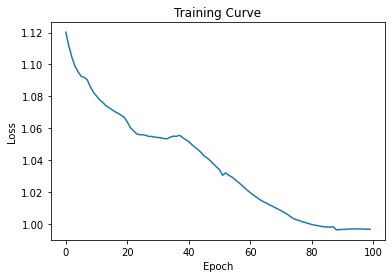

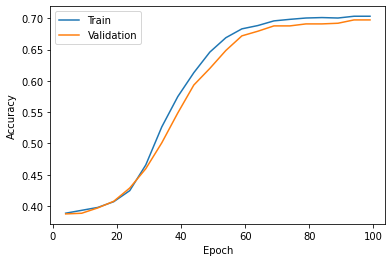

Training time: 352.0811583995819 seconds
Final test accuracy: 0.7016985138004246


In [115]:
train_classifier(model, trainloader, validloader, num_epochs = 100)
print("Final test accuracy:", cal_acc(model, testloader))

# Classification Model

Classification model created using a 3 layer fully connected network.

Model shows 70% accuracy on the test set and validation accuracy seems to have peaked at about 100 epochs. 

As model predicting one of four groups this is significantly better than assigning randomly, therefore model seems to have learnt something about how to classify issues. 

More complicated models could perhaps preform very slightly better but as a compromise between training time and model accuracy this seemed like a good model. 

I believe the best thing for improving model accuracy would be to obtain more data, as the dataset used in the end after balancing was relatively small. 

With more data the model would run more slowly but this could easily be overcome by running the model on a GPU which would be much quicker.


In [141]:
class autoencoder(nn.Module):

  def __init__(self):
    super(autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(582, 300),
        nn.ReLU(True),
        nn.Linear(300, 100),
        nn.ReLU(True),
        nn.Linear(100, 50),
        nn.ReLU(True)
    )

    self.classifier = nn.Sequential(
        nn.Linear(50, 300),
        nn.ReLU(True),
        nn.Linear(300, 100),
        nn.ReLU(True),
        nn.Linear(100, 4)
    )
  
    self.decoder = nn.Sequential(
        nn.Linear(50, 100),
        nn.ReLU(True),
        nn.Linear(100, 300),
        nn.ReLU(True),
        nn.Linear(300, 582)
    )

  def forward(self, x):
    enc_x = self.encoder(x)
    x = self.classifier(enc_x)
    dec_x = self.decoder(enc_x)
  
    return F.softmax(x, dim=1), dec_x

model = autoencoder()
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=582, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=300, out_features=582, bias=True)
  )
)


In [148]:
def train_autoencoder(model, train_loader, valid_loader, num_epochs=100, learning_rate=1e-5, weight_decay = 0.001):
    t0 = time()
    encoder_loss = nn.MSELoss()
    class_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    losses, train_acc, valid_acc = [], [], []
    epochs = []


    for epoch in tqdm(range(num_epochs)):   
      for input, label in train_loader:
          
          #forward pass
          optimizer.zero_grad()
          pred, dec = model(input)
          loss_enc = encoder_loss(dec, input)
          loss_class = class_loss(pred, label)
          loss = 0.5*loss_enc + 0.5*loss_class
          
          #back propagation
          loss.backward()
          optimizer.step()            
            
      losses.append(float(loss))     
      if epoch % 2 == 1:
          epochs.append(epoch)
          train_acc.append(cal_acc_autoencoder(model, train_loader))
          valid_acc.append(cal_acc_autoencoder(model, valid_loader))


    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
    print("Training time:", time() - t0, "seconds")


def cal_acc_autoencoder(model, dataloader):
  correct, total = 0, 0
  with torch.no_grad():
    for input, label in dataloader:
      out, _ = model(input)
      _, pred = torch.max(out, 1)
            
      for i in range(len(label)):
        if pred[i] == label[i]:
          correct += 1
        total += 1
  return correct / total

100%|██████████| 15/15 [01:40<00:00,  6.67s/it]


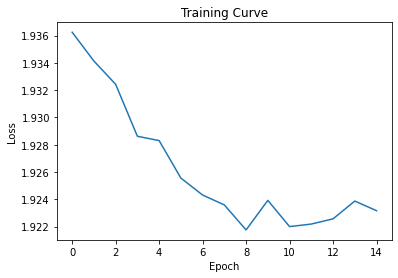

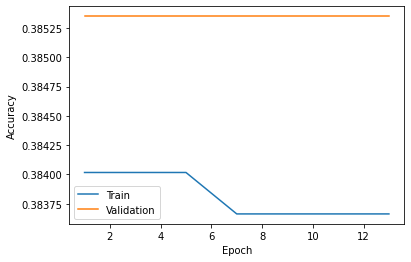

Training time: 100.38484597206116 seconds


In [150]:
train_autoencoder(model, trainloader, validloader, num_epochs = 15)

In [144]:
print("Final test accuracy:", cal_acc(model, testloader))

Final test accuracy: 0.39171974522292996


# Autoencoder model

I also created an autoencoder model. 

As there are relatively large number of inputs (582). I created an autoencoder model also. 

This may be useful for dimension reduction in this problem as it can reduce noise in the data. This allows the dimensionality of the input data to be reduced. 

We can see from the model that the model can use a very similar network for classification as the classification model but takes only 50 input features rather than 582 and returns 40% accuracy. 

Whilst this is not as accurate as the classification model (70% accuracy) but I believe this could be improved as the model had not seemed to converge yet but due to limited time and the slowness of training the model on cpu, I can not further train the model.

Whilst the autoencoder model may not reach the accuracy of the classification model, there are benefits to the autoencoder including dimension reduction, noise reduction and anomaly detection. 

# Conclusion

I believe the classification model returning 70% is acceptable level of accuracy for the given data. I believe this could be improved if more data was obtained. 

The impact of having to discard data to balance the issues in the dataset had a detrimental effect on the performance of the model. However, this was a compromise between the accuracy of the model and the usefulness. For example, accuracy could have been much higher if model only predicted 'Bug' or 'Other' but this would be practically much less useful. 

The autoencoder, although less accurate may be more useful depending on the exact use of the exact use of the network as it can be used for dimension reduction, noise reduction and anomaly detection in the data.
